# Diabetes Hospitalizations

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 120)

### Location of Dataset:

https://data.world/uci/diabetes-130-us-hospitals-for-years-1999-2008

### Article for which data was collected originally:
https://www.hindawi.com/journals/bmri/2014/781670/

## Import Data and Cleaning

In [2]:
df = pd.read_csv('https://query.data.world/s/fzhdybgova7pqh6amwfzrnhumdc26t')

Need to remove time-series elements from when the same patient visited several times. Kept the first entry and removed all others.

In [3]:
df.drop_duplicates(subset='patient_nbr', inplace=True) # 101,766 to 71,518 observations

Weight, Payer Code, and Medical Specialty were missing >50% of values.

In [4]:
df.drop(['encounter_id','patient_nbr','weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

Dropping missing values from Race column.

In [5]:
df = df[df.race != '?']
df = df[df.gender != 'Unknown/Invalid']

Changed target variable to 0-2 for classes (No readmit, less than 30 days, more than 30 days).

In [6]:
df.readmitted.replace({'NO': 0, '<30': 1, '>30': 2}, inplace=True)

Parsing the ICD-9 medical billing codes, in order to grab just 250.xx coding diabetes.

In [7]:
df = df[pd.to_numeric(df['diag_1'], errors='coerce').notnull()] # Select non-null values after changing values to
df = df[pd.to_numeric(df['diag_2'], errors='coerce').notnull()] # numeric (removing V27/V57 entries and ?)
df = df[pd.to_numeric(df['diag_3'], errors='coerce').notnull()] #

df.diag_1 = df.diag_1.astype('float64') # Can now recast from Object to Float64 dtypes (want float to preserve
df.diag_2 = df.diag_2.astype('float64') # ICD-9 decimals as part of the billing code)
df.diag_3 = df.diag_3.astype('float64') #

In [8]:
df.shape

(62754, 45)

## EDA

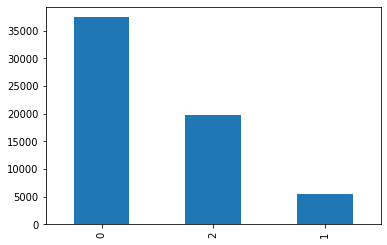

In [9]:
df.readmitted.value_counts().plot(kind='bar')

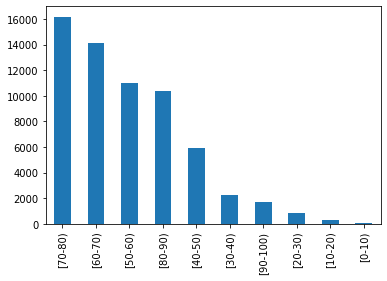

In [10]:
df.age.value_counts().plot(kind='bar')

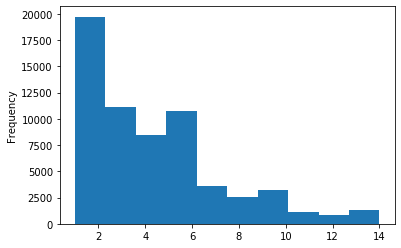

In [11]:
df.time_in_hospital.plot(kind='hist')

## Feature Engineering

Was the patient given a A1C test at all?

In [12]:
df['A1C_test'] = np.where(df.A1Cresult == 'None', 0, 1)

Was the patient's meds changed during the hospitalization?

In [13]:
df.change = np.where(df.change == 'No', 0, 1)

Was the patient tested and meds changed?

In [14]:
df['A1C_test_and_changed'] = np.where((df.change == 1) & (df.A1C_test == 1), 1, 0)

From domain knowledge, patients are readmitted at different rates based on their age brackets.

In [15]:
conditions = [
    (df.age ==  '[0-10)') | (df.age == '[10-20)') | (df.age == '[20-30)'),
    (df.age == '[30-40)') | (df.age == '[40-50)') | (df.age == '[50-60)'),
    (df.age == '[60-70)') | (df.age == '[70-80)') | (df.age == '[80-90)') | (df.age == '[90-100')]

choices = [
    '[0-30)',
    '[30-60]',
    '[60-100)']

In [16]:
df['binned_age'] = np.select(conditions, choices, default=np.nan)

In [17]:
df = df[df.binned_age != 'nan']

Is diabetes one of the three primary diagnoses for the hospitalization?

In [18]:
df['diabetes_as_diag_1'] = np.where((df.diag_1 >= 250) & (df.diag_1 <251), 1, 0)
df['diabetes_as_diag_2'] = np.where((df.diag_2 >= 250) & (df.diag_2 <251), 1, 0)
df['diabetes_as_diag_3'] = np.where((df.diag_3 >= 250) & (df.diag_3 <251), 1, 0)

## Feature Selection

In [25]:
dummies = pd.get_dummies(data=df)
dummies

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,change,readmitted,A1C_test,A1C_test_and_changed,diabetes_as_diag_1,diabetes_as_diag_2,diabetes_as_diag_3,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_No,acetohexamide_Steady,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_No,tolbutamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,metformin-pioglitazone_Steady,diabetesMed_No,diabetesMed_Yes,binned_age_[0-30),binned_age_[30-60],binned_age_[60-100)
1,1,1,7,3,59,0,18,0,0,0,276.0,250.01,255.00,9,1,2,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0
3,1,1,7,2,44,1,16,0,0,0,8.0,250.43,403.00,7,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,0,1,0,1,0
4,1,1,7,1,51,0,8,0,0,0,197.0,157.00,250.00,5,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,1,0,1,0
5,2,1,2,3,31,6,16,0,0,0,414.0,411.00,250.00,9,0,2,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,1,0,1,0
7,1,1,7,5,73,0,12,0,0,0,428.0,492.00,250.00,8,0,2,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,1,1,7,9,50,2,33,0,0,0,574.0,574.00,250.02,9,1,2,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,1
101755,1,1,7,14,73,6,26,0,1,0,592.0,599.00,518.00,9,1,2,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,

In [23]:
dummies.columns

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient',
       ...
       'glipizide-metformin_Steady', 'glimepiride-pioglitazone_No',
       'metformin-rosiglitazone_No', 'metformin-pioglitazone_No',
       'metformin-pioglitazone_Steady', 'diabetesMed_No', 'diabetesMed_Yes',
       'binned_age_[0-30)', 'binned_age_[30-60]', 'binned_age_[60-100)'],
      dtype='object', length=117)

In [26]:
'diabetes_as_diag_1' in dummies.columns

True